In [56]:
import pandas as pd
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np



In [57]:
df_cancer = pd.read_csv("CANCER_TABLE.csv")
df_cancer = df_cancer.rename(columns=lambda x: x.strip())

In [58]:
df_cancer["prediction_cancer"] = df_cancer["diameter (cm)"].apply(lambda x: x>7)

In [59]:
true_labels = df_cancer["cancer"]
predicted_labels = df_cancer["prediction_cancer"]
report = classification_report(true_labels, predicted_labels)
print(report)

              precision    recall  f1-score   support

       False       1.00      0.85      0.92       807
        True       0.62      1.00      0.77       193

    accuracy                           0.88      1000
   macro avg       0.81      0.93      0.84      1000
weighted avg       0.93      0.88      0.89      1000



In [62]:
tn, fn, fp, tp = confusion_matrix(true_labels, predicted_labels).ravel()
print("True Positives (TP):", tp)
print("False Positives (FP):", fp)
print("False Negatives (FN):", fn)
print("True Negatives (TN):", tn)

True Positives (TP): 193
False Positives (FP): 0
False Negatives (FN): 118
True Negatives (TN): 689


<Axes: >

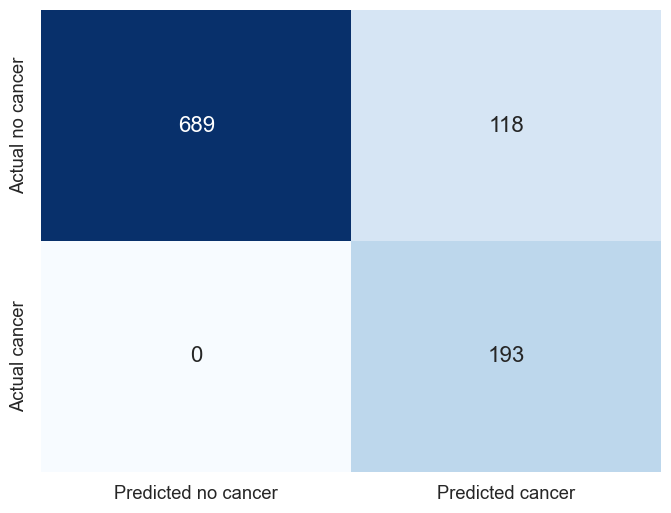

In [64]:
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size for better readability
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16}, cbar=False,
            xticklabels=['Predicted no cancer', 'Predicted cancer'], yticklabels=['Actual no cancer', 'Actual cancer'])

In [6]:
TP = ((true_labels==True) & (predicted_labels==True)).sum()
FP = ((true_labels==False) & (predicted_labels==True)).sum()
FN = ((true_labels == True) & (predicted_labels == False)).sum()
TN = ((true_labels == False) & (predicted_labels == False)).sum()

print("True Positives (TP):", TP)
print("False Positives (FP):", FP)
print("False Negatives (FN):", FN)
print("True Negatives (TN):", TN)

True Positives (TP): 193
False Positives (FP): 118
False Negatives (FN): 0
True Negatives (TN): 689


The business meaning is not so hard to understand.....

In [65]:
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)

print("True Positive Rate (TPR):", TPR)
print("False Positive Rate (FPR):", FPR)

True Positive Rate (TPR): 1.0
False Positive Rate (FPR): 0.14622057001239158


TPR is how many of the positive will I recognize.
FPR is how many of the negatives do I get wrong.

In [66]:
accuracy = np.mean(true_labels == predicted_labels)

print("Accuracy:", accuracy)

Accuracy: 0.882


Acc is what is the probability that my prediction is right.

In [67]:
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.6205787781350482
Recall: 1.0
F1 Score: 0.7658730158730159


After analyzing your model, "Marvel-Sabres" offered an upgrade to the model: instead of a classified model, the company will provide a model that ranks the biopsies by their chances to represent a cancer patient (in the coming year). A higher ranking biopsy represents a higher likelihood that it is taken from a person who gets cancer in the coming year.

#### Why would such a model be good? Market it to a customer
Well instead of just knowing what we think, you can also get a more accurate representation of what is the probability of a patient to have cancer, and not just get an answer based on a given threshold. If you need we can give you a reasonable threshold as well, spereately.

#### Draw a ROC curve without using scikit-Learn or any other structured function of python that does so

In [68]:
def calculate_TPR(true_labels, predicted_labels):
    TP = ((true_labels==True) & (predicted_labels==True)).sum()
    FN = ((true_labels == True) & (predicted_labels == False)).sum()
    TPR = TP / (TP + FN)
    return TPR


def calculate_FPR(true_labels, predicted_labels):
    FP = ((true_labels == False) & (predicted_labels == True)).sum()
    TN = ((true_labels == False) & (predicted_labels == False)).sum()
    FPR = FP / (FP + TN)
    return FPR

thresholds = np.arange(0,20,0.01)

def get_threshold_TPR_FPR(threshold, values, true_labels):
    predicted_labels = np.array([val > threshold for val in values])
    rates = (calculate_TPR(true_labels, predicted_labels), calculate_FPR(true_labels, predicted_labels))
    return rates


In [69]:
threshold_TPR_FPR = np.array([get_threshold_TPR_FPR(thresh, df_cancer["diameter (cm)"], df_cancer["cancer"]) for thresh in thresholds])
TPR = threshold_TPR_FPR[:,0]
FPR = threshold_TPR_FPR[:,1]

In [70]:
# print(TPR)
# print(FPR)
# print(thresholds)

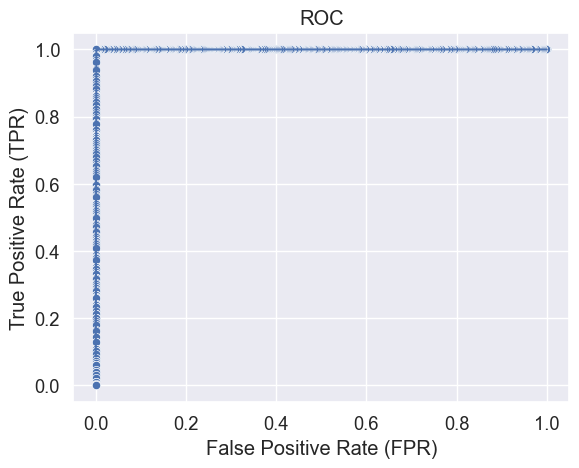

In [92]:
ax = sns.scatterplot(x=FPR, y=TPR)
sns.lineplot(x=FPR, y=TPR)

ax.set_title("ROC")
ax.set_ylabel("True Positive Rate (TPR)")
ax.set_xlabel("False Positive Rate (FPR)")
# ax.set_xlim(0,1)

plt.show()

### Calculate AUC

In [72]:
metrics.auc(FPR,TPR)

1.0

AUC means the area under the curve (ROC curve).
The higher the AUC is the better the model is at identifying correctly positive and negative examples alike.

##### Best thresholds (tpr = 1 and fpr = 0)

In [74]:
#perfect

indices = np.where((threshold_TPR_FPR[:, 0] == 1) & (threshold_TPR_FPR[:, 1] == 0))[0]
print("Best thresholds")
print(thresholds[indices])
chosen_thershold = thresholds[indices][0]

Best thresholds
[7.99 8.   8.01 8.02]


#### Turn the rating model into a classification model using the ROC curve. Explain your answer well.

Ratings = chances for cancerous. Therefore, we find the best threshold using the ROC curve, and use this threshold to decide for each probability wether or not it is cancerous. Each prediction above the threshold we will classify as 1, else 0 (1 is cancerous)

True Positives (TP): 193
False Positives (FP): 0
False Negatives (FN): 0
True Negatives (TN): 807


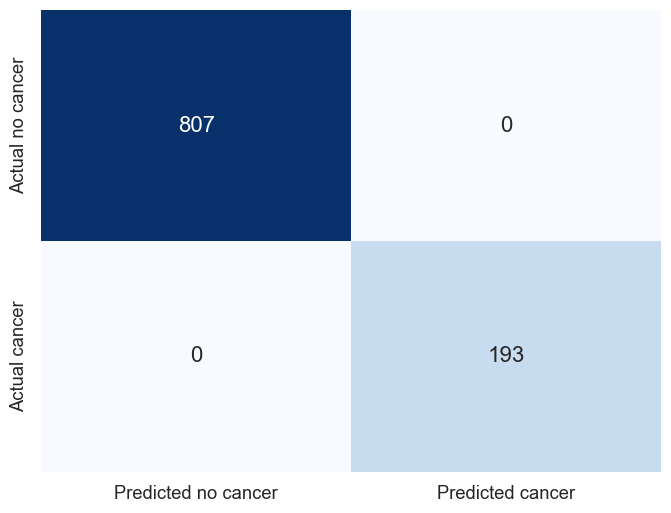

In [76]:
predicted_labels = df_cancer["diameter (cm)"].apply(lambda x: x > chosen_thershold)
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size for better readability
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16}, cbar=False,
            xticklabels=['Predicted no cancer', 'Predicted cancer'], yticklabels=['Actual no cancer', 'Actual cancer'])
tn, fn, fp, tp = cm.ravel()
print("True Positives (TP):", tp)
print("False Positives (FP):", fp)
print("False Negatives (FN):", fn)
print("True Negatives (TN):", tn)

In [78]:
report = classification_report(true_labels, predicted_labels)
print(report)

              precision    recall  f1-score   support

       False       1.00      1.00      1.00       807
        True       1.00      1.00      1.00       193

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



### Compare the measures figured out in the previous section to those of the initial model. What model would you recommend?

I would recommend the second one because it doesn't make mistakes....

### Draw ROC curve again with scikit-Learn library functions while writing a minimum code on your part.

In [90]:
fpr, tpr, thresholds = metrics.roc_curve(true_labels, df_cancer["diameter (cm)"])

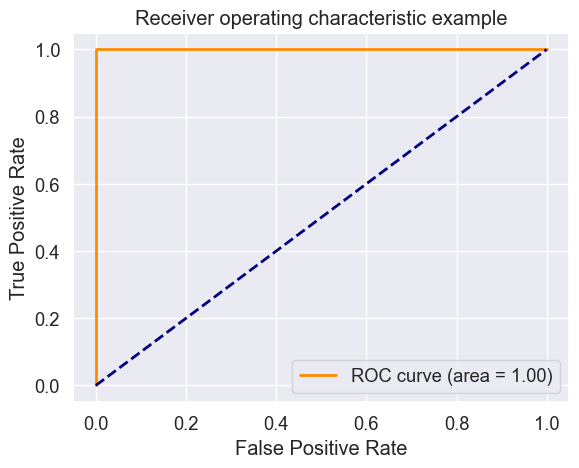

In [91]:
roc_auc = metrics.auc(fpr,tpr)
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()